### Bibliotecas, Funções e Verificações

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.python.client import device_lib
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

2024-05-17 05:43:18.515757: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-17 05:43:19.500181: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2024-05-17 05:43:19.500284: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

In [2]:
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
get_available_gpus()

2024-05-17 05:43:20.615649: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-17 05:43:20.767052: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 05:43:20.782781: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 05:43:20.786087: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

['/device:GPU:0']

In [3]:
def plot_training_history(name, history, Vcm, Tcm, unique_classes):
    fig, axes = plt.subplots(2, 2, figsize=(15, 9))
    
    axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_title('Training and Validation Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid()

    # Plot loss
    axes[0, 1].plot(history.history['loss'], label='Training Loss')
    axes[0, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].set_title('Training and Validation Loss')
    axes[0, 1].legend()
    axes[0, 1].grid()

    axes[1, 0].set_title('Matriz de confusão da validação')
    sns.heatmap(Vcm, ax=axes[1, 0], annot=True, fmt="d", linewidth=.5, cmap="crest", xticklabels=unique_classes, yticklabels=unique_classes)
    axes[1, 1].set_title('Matriz de confusão dos testes')
    sns.heatmap(Tcm, ax=axes[1, 1], annot=True, fmt="d", linewidth=.5, cmap="crest", xticklabels=unique_classes, yticklabels=unique_classes)

    plt.tight_layout(pad=2.0)
    plt.savefig("imgs/" + name + ".png")
    plt.show()

In [4]:
def predict_and_test_model(model, y):
    predictions = model.predict(y)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = y.classes
    cm = confusion_matrix(true_classes, predicted_classes)
    loss, accuracy = model.evaluate(y, verbose=0)
    return cm, loss, accuracy


### Leitura dos dados

In [5]:
# Define paths to your datasets
train_data_dir = "Dataset/train"
validation_data_dir = "Dataset/valid"
test_data_dir = "Dataset/test"

img_width, img_height = 224, 224
batch_size = 16

# Data augmentation and preprocessing for training images
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values to 0-1
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

# Preprocessing for validation and test images (no augmentation)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Load training images from directory
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,  # Adjust as needed based on your system
    class_mode="categorical",
    shuffle=False,
)

# Load validation images from directory
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
)

# Load test images from directory
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
)

Found 1323 images belonging to 7 classes.
Found 345 images belonging to 7 classes.
Found 166 images belonging to 7 classes.


### Criação do modelo

In [6]:
def create_model(input_shape, optimizer, name, n_classes=7, fine_tunning=0):
    conv_base = MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )
    if fine_tunning > 0:
        for layer in conv_base.layers[:-fine_tunning]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(7, activation='softmax')(top_model)

    model = Model(name=name, inputs=conv_base.input, outputs=output_layer)

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [7]:
### Configurações
opt = Adam(learning_rate=0.001)
n_epochs = 50
input_shape = (img_width, img_height, 3)

2024-05-17 05:43:21.899576: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 05:43:21.901826: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 05:43:21.903896: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 05:43:21.907647: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 05:43:21.909675: I tensorflow/compiler/xla/stream_executo

### Entrega 01 - Resultados da CNN apenas com Bootstrap

In [8]:
name = "mobilev2_simples"
modelo = create_model(input_shape, opt, name, 7, 0)
hist = modelo.fit(
    train_generator,
    batch_size=batch_size,
    epochs=n_epochs,
    validation_data=validation_generator,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min'), 
        ModelCheckpoint(filepath=f"weights/{name}.hdf5",save_best_only=True,verbose=1)
    ],
    verbose=1
)


Epoch 1/30


2024-05-17 05:43:27.164683: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8200
2024-05-17 05:43:28.896891: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x5586ba422e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-17 05:43:28.896931: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-05-17 05:43:28.904284: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-17 05:43:29.046059: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


83/83 [==============================] - ETA: 0s - loss: 24.2327 - accuracy: 0.2260
Epoch 1: val_loss improved from inf to 1.86622, saving model to weights/mobilev2_simples.hdf5
83/83 [==============================] - 57s 623ms/step - loss: 24.2327 - accuracy: 0.2260 - val_loss: 1.8662 - val_accuracy: 0.3797
Epoch 2/30
83/83 [==============================] - ETA: 0s - loss: 1.5957 - accuracy: 0.5019
Epoch 2: val_loss improved from 1.86622 to 1.57575, saving model to weights/mobilev2_simples.hdf5
83/83 [==============================] - 49s 594ms/step - loss: 1.5957 - accuracy: 0.5019 - val_loss: 1.5757 - val_accuracy: 0.4957
Epoch 3/30
83/83 [==============================] - ETA: 0s - loss: 0.9674 - accuracy: 0.6591
Epoch 3: val_loss improved from 1.57575 to 0.83853, saving model to weights/mobilev2_simples.hdf5
83/83 [==============================] - 49s 593ms/step - loss: 0.9674 - accuracy: 0.6591 - val_loss: 0.8385 - val_accuracy: 0.6348
Epoch 4/30
83/83 [=======================

Dados do Treino:
	Ultima acurácia durante o treino: 0.9123
	Melhor acurácia durante o treino: 0.9652
Dados de Validação:
	Ultimo Loss durante o treino: 0.3492
	Melhor Loss durante o treino: 0.1170
11/11 [==============================] - 1s 82ms/step
Avaliação com os dados de validação:
	Acurácia: 0.8261
	Loss: 0.5975
Avaliação com os dados de testes:
	Acurácia: 0.8494
	Loss: 0.3942


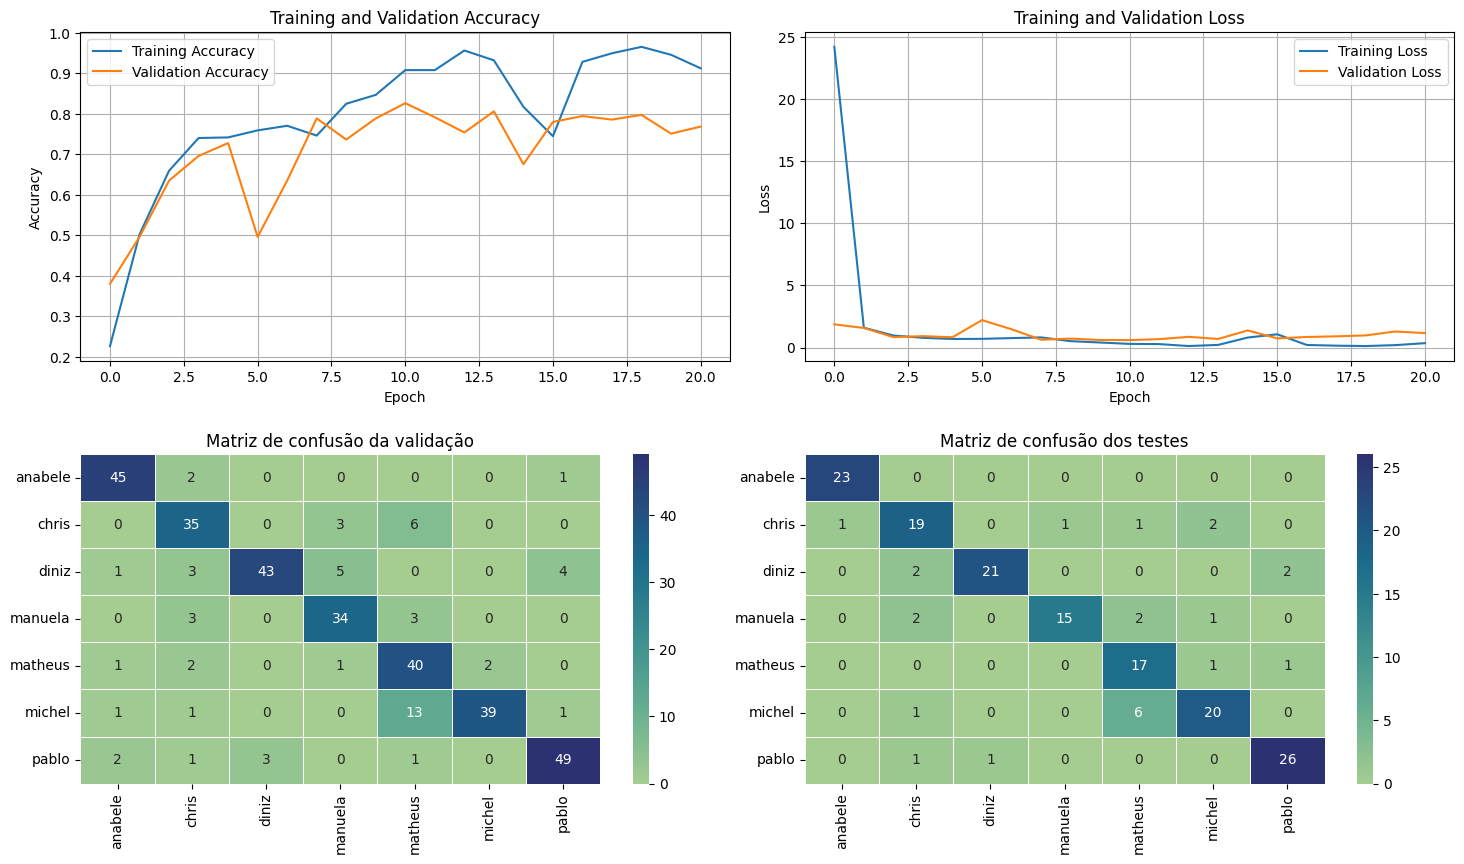

In [9]:
pd.DataFrame(hist.history).to_csv(f'weights/{name}.csv')
Vcm, Vloss, Vacc = predict_and_test_model(modelo, validation_generator)
Tcm, Tloss, Tacc = predict_and_test_model(modelo, test_generator)
unique_classes = list(test_generator.class_indices.keys())
print("Dados do Treino:")
print("\tUltima acurácia durante o treino: {:.4f}".format(hist.history["accuracy"][-1]))
print("\tMelhor acurácia durante o treino: {:.4f}".format(max(hist.history["accuracy"])))
print("Dados de Validação:")
print("\tUltimo Loss durante o treino: {:.4f}".format(hist.history["loss"][-1]))
print("\tMelhor Loss durante o treino: {:.4f}".format(min(hist.history["loss"])))
print(f"Avaliação com os dados de testes:\n\tAcurácia: {Tacc:.4f}\n\tLoss: {Tloss:.4f}")
plot_training_history(name, hist, Vcm, Tcm, unique_classes)

### Entrega 02 - CNN com Fine tunning

#### Fine tunning = 10

In [10]:
name = "mobilev2_fine_tunning_10"
modelo_simples = create_model(input_shape, opt, name, fine_tunning=10)
hist = modelo.fit(
    train_generator,
    batch_size=batch_size,
    epochs=n_epochs,
    validation_data=validation_generator,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min'), 
        ModelCheckpoint(filepath=f"weights/{name}.hdf5",save_best_only=True,verbose=1)
    ],
    verbose=1
)

Epoch 1/30
83/83 [==============================] - ETA: 0s - loss: 0.5017 - accuracy: 0.8587
Epoch 1: val_loss improved from inf to 0.81731, saving model to weights/mobilev2_fine_tunning_10.hdf5
83/83 [==============================] - 25s 302ms/step - loss: 0.5017 - accuracy: 0.8587 - val_loss: 0.8173 - val_accuracy: 0.7652
Epoch 2/30
83/83 [==============================] - ETA: 0s - loss: 0.3846 - accuracy: 0.8692
Epoch 2: val_loss improved from 0.81731 to 0.77966, saving model to weights/mobilev2_fine_tunning_10.hdf5
83/83 [==============================] - 49s 599ms/step - loss: 0.3846 - accuracy: 0.8692 - val_loss: 0.7797 - val_accuracy: 0.7710
Epoch 3/30
83/83 [==============================] - ETA: 0s - loss: 0.3374 - accuracy: 0.8972
Epoch 3: val_loss did not improve from 0.77966
83/83 [==============================] - 18s 214ms/step - loss: 0.3374 - accuracy: 0.8972 - val_loss: 0.8438 - val_accuracy: 0.7768
Epoch 4/30
83/83 [==============================] - ETA: 0s - loss:

11/11 [==============================] - 1s 54ms/step
Dados de validação:
	Acurácia: 0.8377
	Loss: 0.7156
Dados de validação:
	Acurácia: 0.8614
	Loss: 0.5498


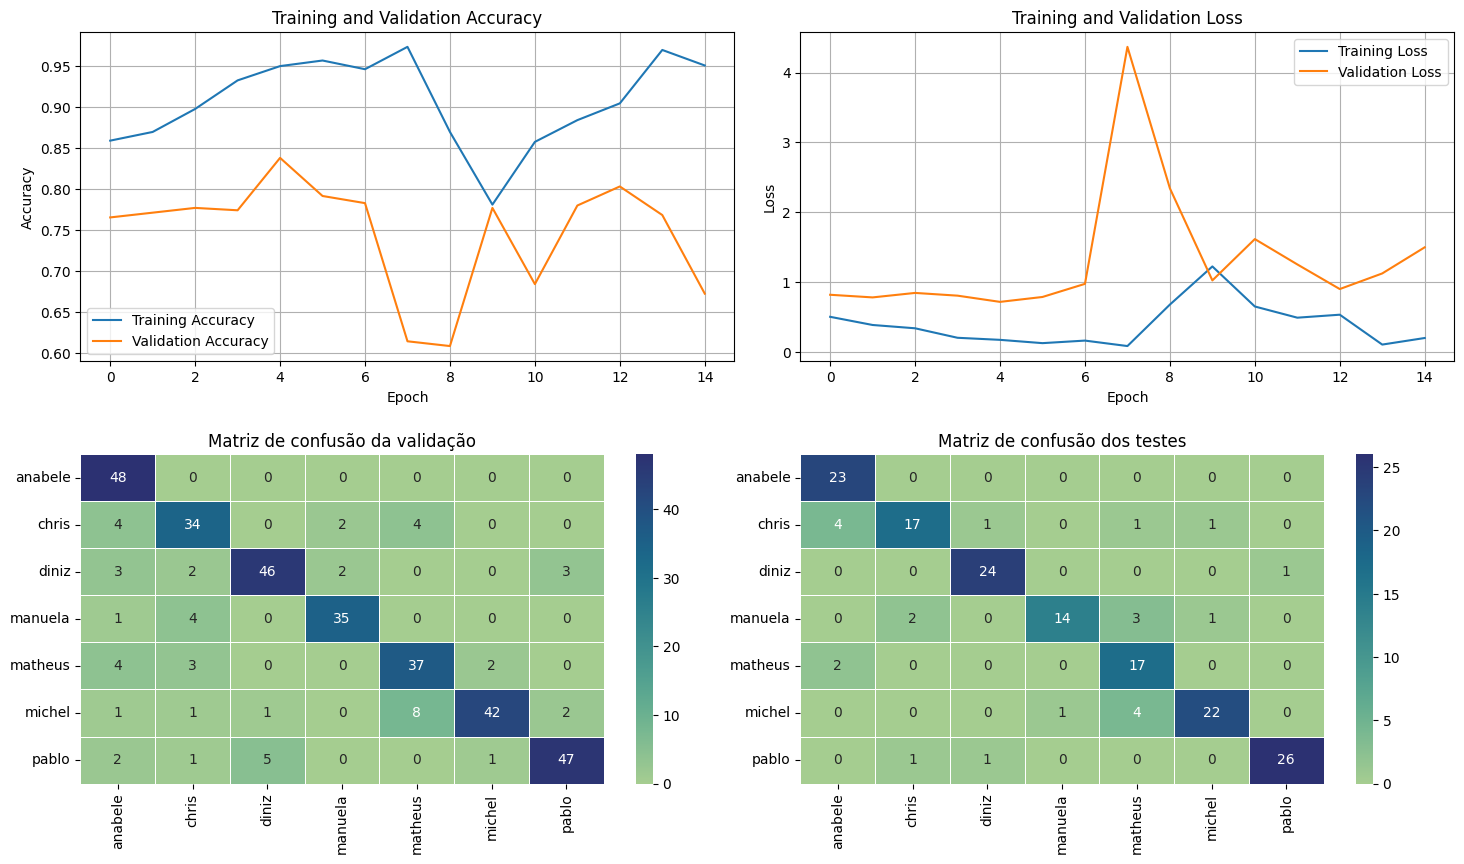

In [11]:
pd.DataFrame(hist.history).to_csv(f'weights/{name}.csv')
Vcm, Vloss, Vacc = predict_and_test_model(modelo, validation_generator)
Tcm, Tloss, Tacc = predict_and_test_model(modelo, test_generator)
unique_classes = list(test_generator.class_indices.keys())
print("Dados do Treino:")
print("\tUltima acurácia durante o treino: {:.4f}".format(hist.history["accuracy"][-1]))
print("\tMelhor acurácia durante o treino: {:.4f}".format(max(hist.history["accuracy"])))
print("Dados de Validação:")
print("\tUltimo Loss durante o treino: {:.4f}".format(hist.history["loss"][-1]))
print("\tMelhor Loss durante o treino: {:.4f}".format(min(hist.history["loss"])))
print(f"Avaliação com os dados de testes:\n\tAcurácia: {Tacc:.4f}\n\tLoss: {Tloss:.4f}")
plot_training_history(name, hist, Vcm, Tcm, unique_classes)

#### Fine tunning = 25

In [12]:
name = "mobilev2_fine_tunning_25"
modelo_simples = create_model(input_shape, opt, name, fine_tunning=25)
hist = modelo.fit(
    train_generator,
    batch_size=batch_size,
    epochs=n_epochs,
    validation_data=validation_generator,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min'), 
        ModelCheckpoint(filepath=f"weights/{name}.hdf5",save_best_only=True,verbose=1)
    ],
    verbose=1
)

Epoch 1/30
83/83 [==============================] - ETA: 0s - loss: 0.2793 - accuracy: 0.9184
Epoch 1: val_loss improved from inf to 0.67861, saving model to weights/mobilev2_fine_tunning_25.hdf5
83/83 [==============================] - 25s 302ms/step - loss: 0.2793 - accuracy: 0.9184 - val_loss: 0.6786 - val_accuracy: 0.8087
Epoch 2/30
83/83 [==============================] - ETA: 0s - loss: 0.2491 - accuracy: 0.9448
Epoch 2: val_loss did not improve from 0.67861
83/83 [==============================] - 18s 218ms/step - loss: 0.2491 - accuracy: 0.9448 - val_loss: 1.0899 - val_accuracy: 0.7304
Epoch 3/30
83/83 [==============================] - ETA: 0s - loss: 0.1336 - accuracy: 0.9599
Epoch 3: val_loss did not improve from 0.67861
83/83 [==============================] - 18s 217ms/step - loss: 0.1336 - accuracy: 0.9599 - val_loss: 0.9167 - val_accuracy: 0.7652
Epoch 4/30
83/83 [==============================] - ETA: 0s - loss: 0.0694 - accuracy: 0.9758
Epoch 4: val_loss did not improv

11/11 [==============================] - 1s 59ms/step
Dados de validação:
	Acurácia: 0.8087
	Loss: 0.6786
Dados de validação:
	Acurácia: 0.8614
	Loss: 0.6199


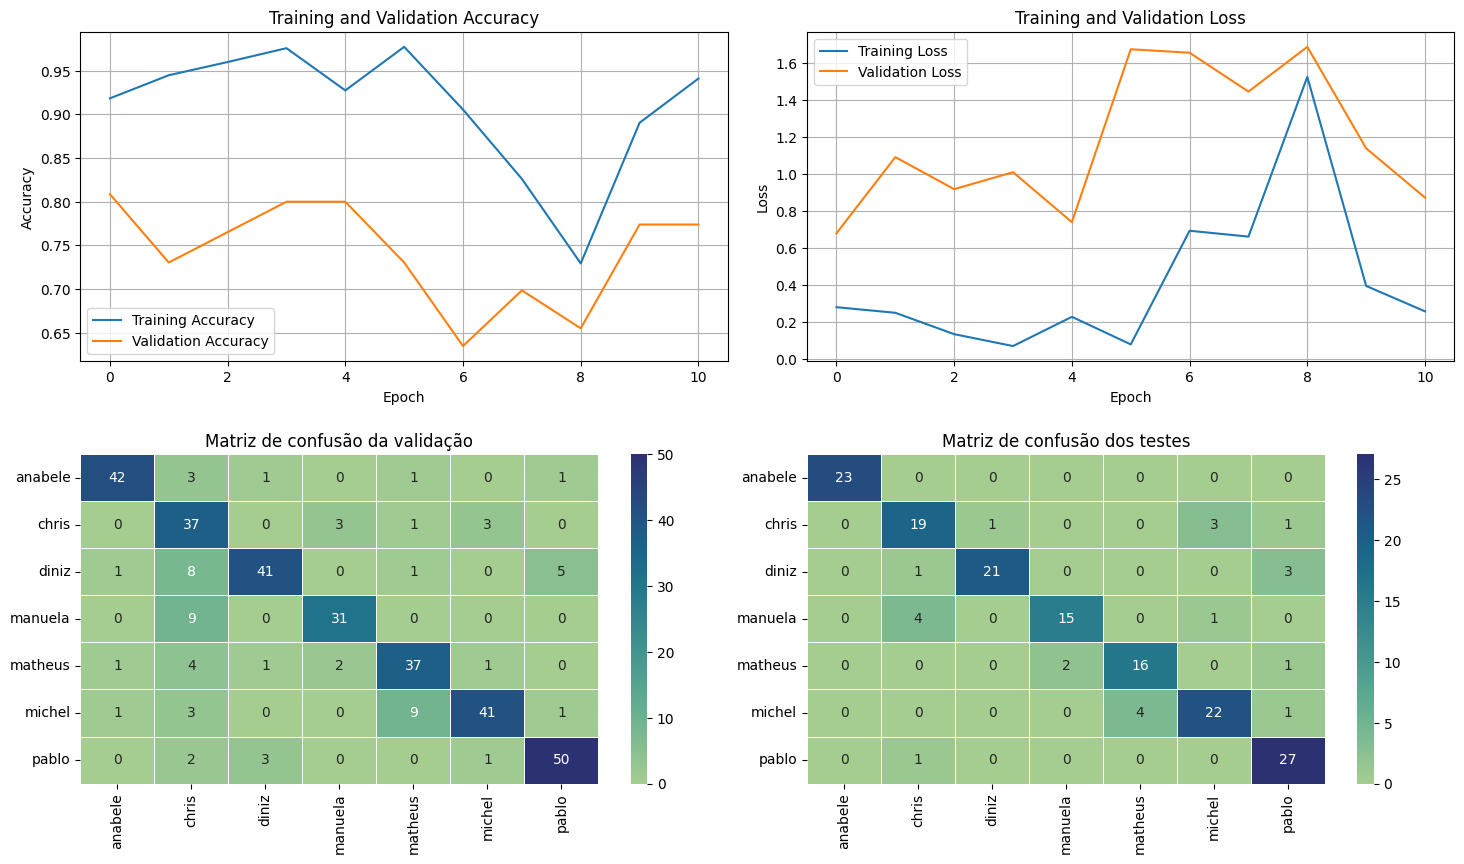

In [13]:
pd.DataFrame(hist.history).to_csv(f'weights/{name}.csv')
Vcm, Vloss, Vacc = predict_and_test_model(modelo, validation_generator)
Tcm, Tloss, Tacc = predict_and_test_model(modelo, test_generator)
unique_classes = list(test_generator.class_indices.keys())
print("Dados do Treino:")
print("\tUltima acurácia durante o treino: {:.4f}".format(hist.history["accuracy"][-1]))
print("\tMelhor acurácia durante o treino: {:.4f}".format(max(hist.history["accuracy"])))
print("Dados de Validação:")
print("\tUltimo Loss durante o treino: {:.4f}".format(hist.history["loss"][-1]))
print("\tMelhor Loss durante o treino: {:.4f}".format(min(hist.history["loss"])))
print(f"Avaliação com os dados de testes:\n\tAcurácia: {Tacc:.4f}\n\tLoss: {Tloss:.4f}")
plot_training_history(name, hist, Vcm, Tcm, unique_classes)

#### Fine tunning = 50

In [14]:
name = "mobilev2_fine_tunning_50"
modelo_simples = create_model(input_shape, opt, name, fine_tunning=50)
hist = modelo.fit(
    train_generator,
    batch_size=batch_size,
    epochs=n_epochs,
    validation_data=validation_generator,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min'), 
        ModelCheckpoint(filepath=f"weights/{name}.hdf5",save_best_only=True,verbose=1)
    ],
    verbose=1
)

Epoch 1/30
83/83 [==============================] - ETA: 0s - loss: 0.2390 - accuracy: 0.9252
Epoch 1: val_loss improved from inf to 1.27163, saving model to weights/mobilev2_fine_tunning_50.hdf5
83/83 [==============================] - 25s 306ms/step - loss: 0.2390 - accuracy: 0.9252 - val_loss: 1.2716 - val_accuracy: 0.7826
Epoch 2/30
83/83 [==============================] - ETA: 0s - loss: 0.3843 - accuracy: 0.9138
Epoch 2: val_loss improved from 1.27163 to 0.68938, saving model to weights/mobilev2_fine_tunning_50.hdf5
83/83 [==============================] - 49s 598ms/step - loss: 0.3843 - accuracy: 0.9138 - val_loss: 0.6894 - val_accuracy: 0.8145
Epoch 3/30
83/83 [==============================] - ETA: 0s - loss: 0.2319 - accuracy: 0.9327
Epoch 3: val_loss did not improve from 0.68938
83/83 [==============================] - 18s 212ms/step - loss: 0.2319 - accuracy: 0.9327 - val_loss: 0.9280 - val_accuracy: 0.7681
Epoch 4/30
83/83 [==============================] - ETA: 0s - loss:

11/11 [==============================] - 1s 55ms/step
Dados de validação:
	Acurácia: 0.8145
	Loss: 0.6894
Dados de validação:
	Acurácia: 0.8373
	Loss: 0.6770


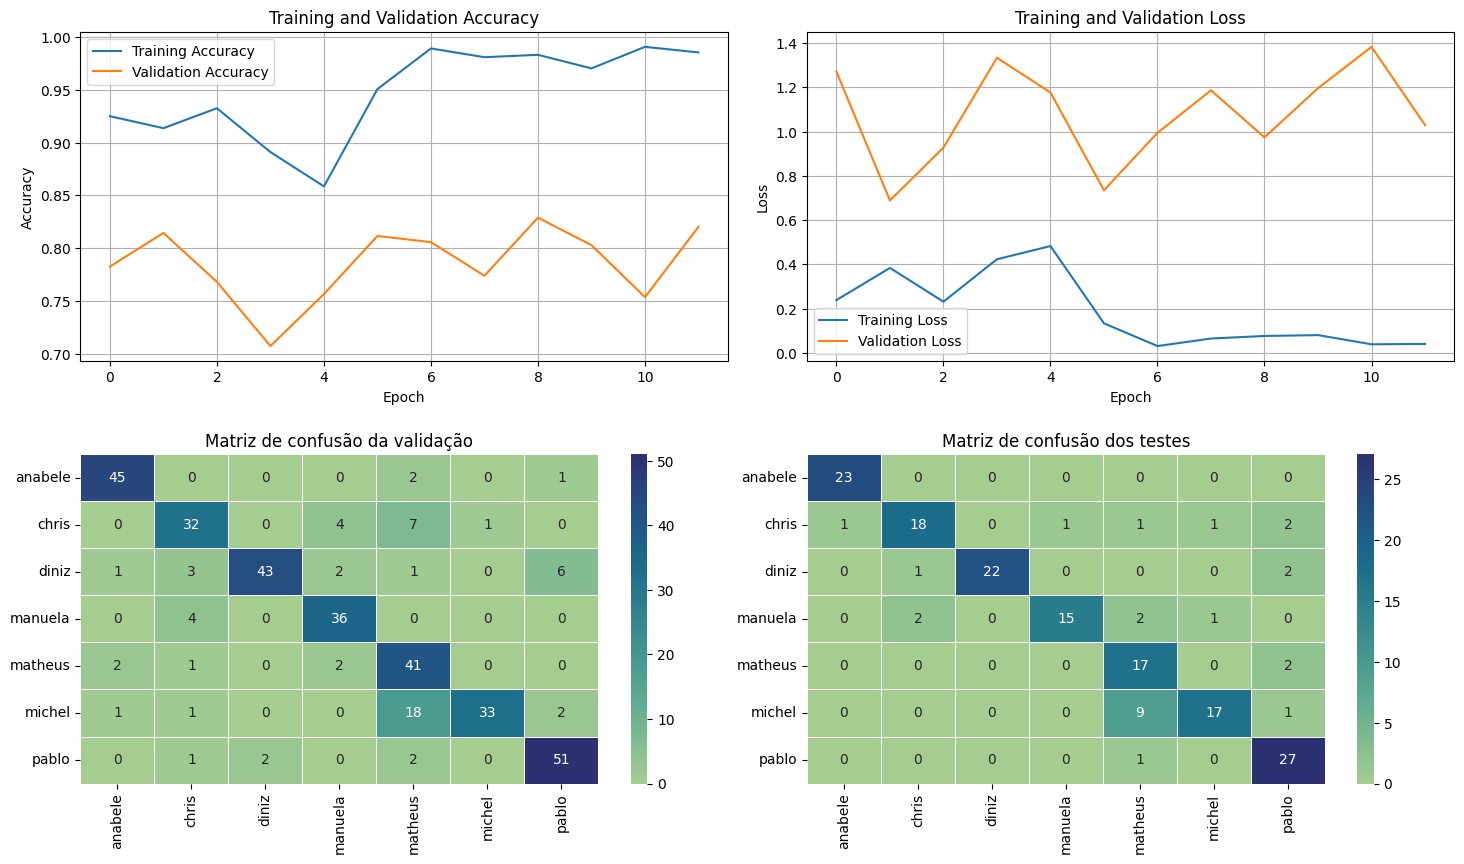

In [15]:
pd.DataFrame(hist.history).to_csv(f'weights/{name}.csv')
Vcm, Vloss, Vacc = predict_and_test_model(modelo, validation_generator)
Tcm, Tloss, Tacc = predict_and_test_model(modelo, test_generator)
unique_classes = list(test_generator.class_indices.keys())
print("Dados do Treino:")
print("\tUltima acurácia durante o treino: {:.4f}".format(hist.history["accuracy"][-1]))
print("\tMelhor acurácia durante o treino: {:.4f}".format(max(hist.history["accuracy"])))
print("Dados de Validação:")
print("\tUltimo Loss durante o treino: {:.4f}".format(hist.history["loss"][-1]))
print("\tMelhor Loss durante o treino: {:.4f}".format(min(hist.history["loss"])))
print(f"Avaliação com os dados de testes:\n\tAcurácia: {Tacc:.4f}\n\tLoss: {Tloss:.4f}")
plot_training_history(name, hist, Vcm, Tcm, unique_classes)

### Entrega 03 - Pré processamento e Bootstrap

### Entrega 04 - Pré processamento e fine tunning

### Entrega 05 - Relatório